# Redes Bayesianas Discretas: Introducción a Bnlearn

Master in Data Science - Machine Learning II

Santander Meteorology Group,

Profesor: Mikel N. Legasa (legasam@unican.es)

6 Mar 2018

La presente práctica esta concebida como una primera aproximación a los fundamentos de las redes bayesianas, encargándonos simplemente de la modelización de variables discretas mediante una red bayesiana siguiendo el esquema:

  - [Introducción](#1-Introducción)
  - [Construcción de la red bayesiana](#2-Construcción-de-la-Red-Bayesiana), tanto su estructura (Construcción del DAG) y sus parámetros (Construcción de las tablas de probabilidad condicionada)
  - Obtención de información cualitativa a partir del grafo (Consultas al grafo).

Con la idea de familiarizarnos con la librería bnlearn y sus estructuras y funciones.

## 1 Introducción

### 1.1 Dataset de ejemplo: ‘survey’

Utilizaremos los datos de una encuesta sobre utilización de medios de transporte, donde cada variable tiene un número finito de posibles estados. A partir de los datos de campo recogidos por la encuesta, se investigará la selección de medios de transporte por distintos perfiles de usuarios, y particularmente la preferencia de tren o coche. Este tipo de análisis se utiliza con frecuencia en la planificación de infraestructuras. Para cada individuo encuestado, se han recopilado datos referentes a 6 variables discretas. Las abreviaturas de dichas variables se muestran entre paréntesis (original del dataset en inglés), y se utilizarán a lo largo de la práctica para referirse a los nodos de la red creada.

  - Edad (A): Edad del encuestado: joven (young, < 30 años), adulto (adult, 30 < edad <= 60) y anciano (old, edad > 60).
  - Sexo (S): Sexo del encuestado: masculino (M) y femenino (F).
  - Educación (E): Nivel más alto de educación alcanzado: Hasta educación secundaria (high) o título universitario (uni).
  - Ocupación (O): trabajador por cuenta ajena (emp) o autónomo (self).
  - Residencia (R): Tamaño de la población de residencia del individuo: big y small.
  - Transporte (T): Medio de transporte más utilizado por el encuestado para acudir al trabajo: car, train y other.

### 1.2 Paquetes de R necesarios

Se utilizará el paquete de R bnlearn (bayesian network learning), disponible a través de CRAN:

```r
install.packages("bnlearn")
```

Además, se necesitan dependencias adicionales que no están en CRAN, sinó en Bioconductor:

```r
# (bioconductor)
source("http://bioconductor.org/biocLite.R")

# Para la inferencia
biocLite("RBGL")
# Para la parte de visualización de grafos:
biocLite("Rgraphviz")
# Para manejo de grafos:
# Paquete gRain
install.packages("gRain")
```

In [1]:
#::GMG::Yo ya instalé esos paquetes en la sesión lab de introducción
#       Ahora cargo la biblioteca que necesito
library('bnlearn')


Attaching package: ‘bnlearn’

The following object is masked from ‘package:stats’:

    sigma



## 2 Construcción de la Red Bayesiana

### 2.1 Construcción del DAG

Para estos datos trataremos de [construir manualmente un grafo](http://www.bnlearn.com/examples/dag/) que verifique $⊥_G ⇒ ⊥_P$, tratando de definir las dependencias e independencias que consideremos intuitivamente que se dan entre las variables, con el objetivo final de modelizar los datos, i.e. de aproximar la Distribución de Probabilidad Conjunta de los datos $P$.

Para crear un grafo que contenga un nodo por cada variable considerada en la encuesta utilizamos la función [`empty.graph()`](http://www.bnlearn.com/documentation/man/graphgen.html), que pertenece a *bnlearn* e inicializa un grafo vacío como clase bn:

In [2]:
#::GMG::Creo de forma "experta" (custom) el dag de survey
# http://www.bnlearn.com/examples/dag/
#::nota::el orden de los nodos es relevante en la visualización
#        ya que aparecen en el orden en que aparecen en el dataset
# A		R	E	O	S	T
#::nota::aquí no vamos a usar para nada el dataset ... vamos a seguir
#        la vía que nos han indicado como "sistema experto"
dag <- empty.graph(nodes = c("A", "R", "E", "O", "S", "T"))
class(dag)

[1] "bn"

Nombramos a nuestro grafo vacío `dag` (*directed acyclic graph*). Esta es la información contenida en el grafo:

In [3]:
print(dag)


  Random/Generated Bayesian network

  model:
   [A][R][E][O][S][T] 
  nodes:                                 6 
  arcs:                                  0 
    undirected arcs:                     0 
    directed arcs:                       0 
  average markov blanket size:           0.00 
  average neighbourhood size:            0.00 
  average branching factor:              0.00 

  generation algorithm:                  Empty 



Este objeto se organiza como una lista, de manera que podemos acceder a sus elementos mediante `dag$learning`, etc…

In [4]:
#::GMG::Pruebo esa estructura (me puede ser útil en el futuro)
# http://www.bnlearn.com/documentation/man/bn.fit.class.html
dag$learning

$whitelist
NULL

$blacklist
NULL

$test
[1] "none"

$ntests
[1] 0

$algo
[1] "empty"

$args
list()

In [5]:
#::GMG::Cada nodo contiene el nombre, markov blanket,
#       neighborhood, parents y children
dag$nodes

$A
$A$mb
character(0)

$A$nbr
character(0)

$A$parents
character(0)

$A$children
character(0)


$R
$R$mb
character(0)

$R$nbr
character(0)

$R$parents
character(0)

$R$children
character(0)


$E
$E$mb
character(0)

$E$nbr
character(0)

$E$parents
character(0)

$E$children
character(0)


$O
$O$mb
character(0)

$O$nbr
character(0)

$O$parents
character(0)

$O$children
character(0)


$S
$S$mb
character(0)

$S$nbr
character(0)

$S$parents
character(0)

$S$children
character(0)


$T
$T$mb
character(0)

$T$nbr
character(0)

$T$parents
character(0)

$T$children
character(0)

In [6]:
#::GMG::De momento no hay definido ningún arco 
dag$arcs

from,to


En secciones posteriores veremos como hacer representaciones gráficas más detalladas, pero de momento basta con aplicar `plot()` para ir viendo la estructura básica de la red. Una vez creados los nodos, comenzamos a añadir los arcos que definen las dependencias directas entre las diferentes variables y que parezcan razonables.

La *edad* y el *sexo* son indicadores demográficos y no reciben influencia de ninguna otra variable, ya que son características intrínsecas del individuo. Por lo tanto, *ninguno de los arcos del grafo apuntan hacia ellas*.

Por otra parte, parece razonable que ambas variables (sexo y edad) *tengan una influencia directa sobre el nivel de educación*, ya que el número de estudiantes universitarios ha aumentado en las últimas décadas, y por lo tanto personas más jóvenes tienen más probabilidad de tener un título universitario que otras más mayores:

In [7]:
#::GMG::establecer un arco significa que NO hay independencia (a priori)
dag <- set.arc(dag, from = "A", to = "E")

Del mismo modo, el sexo tiene influencia sobre la educación, ya que las estadísticas demuestran que en la actualidad hay un mayor número de mujeres que de hombres completando estudios universitarios:

In [8]:
dag <- set.arc(dag, from = "S", to = "E")

In [9]:
#::GMG::Ya tengo los primeros arcos dirigidos en el grafo
dag$arcs

from,to
A,E
S,E


In [10]:
#::GMG::Los nodos implicados tienen padres e hijos
dag$nodes$A

$mb
[1] "E" "S"

$nbr
[1] "E"

$parents
character(0)

$children
[1] "E"

In [11]:
dag$nodes$E

$mb
[1] "A" "S"

$nbr
[1] "A" "S"

$parents
[1] "A" "S"

$children
character(0)

Tras añadir dos arcos, este es el aspecto que va tomando el grafo:

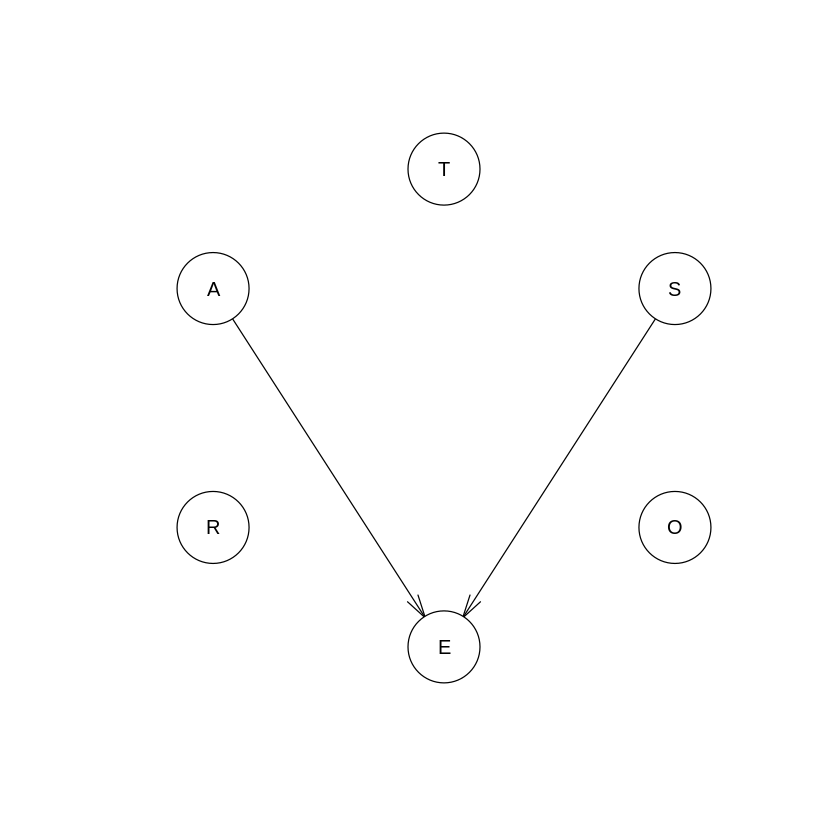

In [12]:
plot(dag)

El nivel de educación tiene una fuerte influencia en la ocupación del individuo, así como en su lugar de residencia:

In [13]:
dag <- set.arc(dag, from = "E", to = "O") 
dag <- set.arc(dag, from = "E", to = "R")

Finalmente, los medios de transporte preferidos por el individuo están directamente influidos por su lugar de residencia y su ocupación. En cuanto al primer factor, la distancia al lugar de trabajo desde la residencia influye directamente en la opción de transporte. Por otra parte, algunos trabajos requieren viajes periódicos de larga distancia, mientras que otros requieren trayectos más frecuentes sobre cortas distancias.

In [14]:
dag <- set.arc(dag, from = "R", to = "T")
dag <- set.arc(dag, from = "O", to = "T")

Finalmente, queda definido el grafo como:

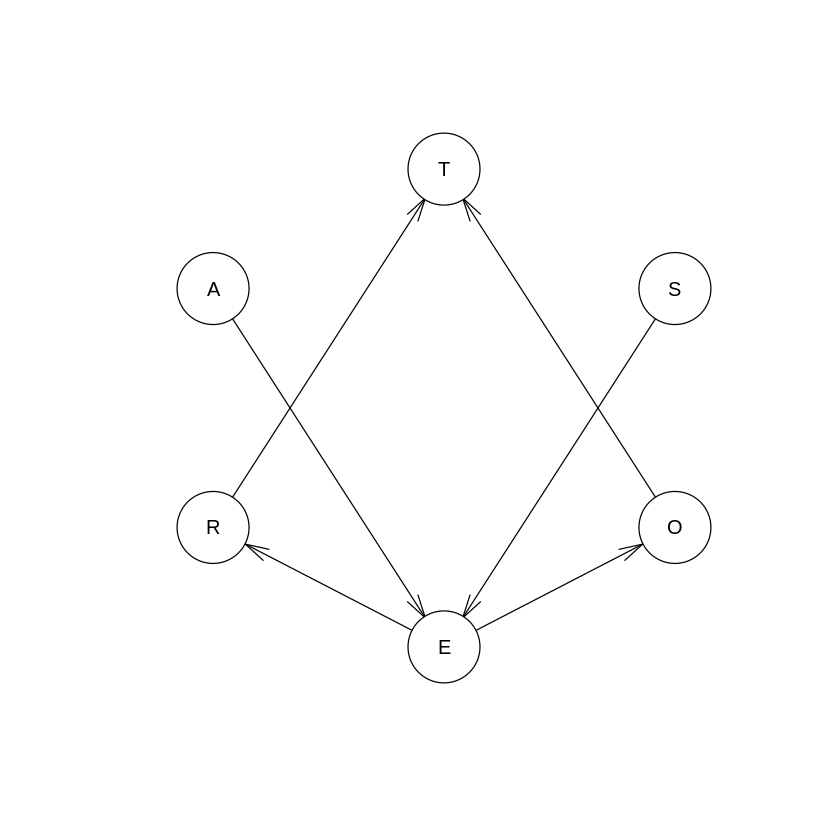

In [15]:
plot(dag)

In [16]:
#::GMG::Hemos definido los arcos
dag$arcs

from,to
A,E
S,E
E,O
E,R
R,T
O,T


In [17]:
#::GMG::Y los nodos
dag$nodes

$A
$A$mb
[1] "E" "S"

$A$nbr
[1] "E"

$A$parents
character(0)

$A$children
[1] "E"


$R
$R$mb
[1] "E" "O" "T"

$R$nbr
[1] "E" "T"

$R$parents
[1] "E"

$R$children
[1] "T"


$E
$E$mb
[1] "A" "R" "O" "S"

$E$nbr
[1] "A" "R" "O" "S"

$E$parents
[1] "A" "S"

$E$children
[1] "R" "O"


$O
$O$mb
[1] "R" "E" "T"

$O$nbr
[1] "E" "T"

$O$parents
[1] "E"

$O$children
[1] "T"


$S
$S$mb
[1] "A" "E"

$S$nbr
[1] "E"

$S$parents
character(0)

$S$children
[1] "E"


$T
$T$mb
[1] "R" "O"

$T$nbr
[1] "R" "O"

$T$parents
[1] "R" "O"

$T$children
character(0)

Esta es la definición simbólica del grafo:

In [18]:
modelstring(dag)

[1] "[A][S][E|A:S][R|E][O|E][T|R:O]"

De este modo, las dependencias de cada variable quedan definidas por la barra vertical (`|`) que usamos habitualmente para la fórmula de probabilidad condicionada y separadas por dos puntos `:`. Por ejemplo, `[E|A:S]` significa que se dan los arcos $A→E$ y $S→E$ (sexo y edad son *padres* de empleo). Esta notación se asemeja por tanto a un producto de probabilidades condicionadas, del tipo $P(E | A,S)$, lo que concuerda con el hecho de que cada una de ellas es un *factor de la descomposición* en la *distribución global* hecha por nuestro grafo `dag`:

$P_{dag}\left(A,S,E,O,R,T\right) = P(A)P(S)P(E | A,S)P(O | E)P(R | E)P(T | O,R)$

Otras funciones útiles para explorar objetos de la clase bn son por ejemplo nodesy arcs:

In [19]:
#::GMG::muchas de las estructuras de la clase bn se pueden obtener 
#       de manera funcional con una visión simplificada
nodes(dag)

[1] "A" "R" "E" "O" "S" "T"

In [20]:
arcs(dag)

from,to
A,E
S,E
E,O
E,R
R,T
O,T


### 2.2 Otra manera de definir el DAG

La forma anterior define arcos uno a uno, pero también podemos definir la estructura toda a la vez. La función `arcs()` es especialmente interesante ya que nos permite añadir arcos de manera más rápida. En este caso, se podrían definir las relaciones mediante una matriz de dos columnas similar a la devuelta por `arcs()`:

In [21]:
dag2 <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))
arc.set <- matrix(c("A", "E",
                    "S", "E",
                    "E", "R",
                    "E", "O",
                    "O", "T",
                    "R", "T"),
                  byrow = TRUE, ncol = 2,
                  dimnames = list(NULL, c("from", "to"))
                 )
arcs(dag2) <- arc.set

El grafo resultante es idéntico al que se generó anteriormente:

In [22]:
all.equal(dag, dag2)

[1] TRUE

Ambas formas de definir el grafo garantizan que éste sea acíclico, ya que si se intenta introducir un ciclo en el mismo se producirá un error. Por ejemplo, si intentamos crear una relación directa entre `T` y `E`, lo que daría lugar a un ciclo, se produce un error:

In [23]:
set.arc(dag, from = "T", to = "E")

ERROR: Error in arc.operations(x = x, from = from, to = to, op = "set", check.cycles = check.cycles, : the resulting graph contains cycles.


### Ejercicio 1.1

Construye un grafo razonable que modelice el conjunto de datos almacenados en coronary, que contiene las causas probables de factores de riesgo en trombosis coronaria, con las variables:

 - Smoking: Fumador. Factores: no/yes .
 - M. Work: Trabajo mental estresante. Factores: no/yes .
 - P. Work: Trabajo físico estresante. Factores: no/yes
 - Pressure: Tensión sistólica. Factores: <140/>140
 - Proteins: Ratio de lipoproteinas alfa y beta. Factores: <3/>3.
 - Family: Familiar con enfermedad coronaria: Factores: neg/pos
 
**::GMG::** La [solución](http://www.bnlearn.com/documentation/man/coronary.html) parcial (grafo no dirigido) está en la documentación de referencia de `bnlearn` que incluye el dataset `coronary` en el que se tienen las características que se indican en el ejercicio.

In [24]:
#::GMG::El dataset coronary
str(coronary)

'data.frame':	1841 obs. of  6 variables:
 $ Smoking : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ M. Work : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ P. Work : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ Pressure: Factor w/ 2 levels "<140",">140": 1 1 1 1 1 1 1 1 1 1 ...
 $ Proteins: Factor w/ 2 levels "<3",">3": 1 1 1 1 1 1 1 1 1 1 ...
 $ Family  : Factor w/ 2 levels "neg","pos": 1 1 1 1 1 1 1 1 1 1 ...


In [25]:
#::GMG::Ejemplo (solución) de la documentación
# http://www.bnlearn.com/documentation/man/coronary.html
# This is the undirected graphical model from Whittaker (1990).
#data(coronary)
#::nota::es interesante la manera de sacar el nombre de los nodos
#        del dataset
ug <- empty.graph(names(coronary))

In [26]:
#::GMG::En clase nos han indicado que no es una buena idea poner
#       nodos con nombres con espacios y la extracción no names()
#       los elimina (!!)
nodes(ug)

[1] "Smoking"  "M. Work"  "P. Work"  "Pressure" "Proteins" "Family"

In [27]:
#::GMG::La función arcs() también se puede usar para crear
#       los arcos (!!)
#::nota::al poner las dos direcciones de un arco se le hace
#        no dirigido
#::PTE::con asunciones (razonamientos) parecidos a los usados con
#       el dag de survey 
arcs(x = ug, check.cycles = FALSE) = matrix(
  c("Family", "M. Work", "M. Work", "Family",
    "M. Work", "P. Work", "P. Work", "M. Work",
    "M. Work", "Proteins", "Proteins", "M. Work",
    "M. Work", "Smoking", "Smoking", "M. Work",
    "P. Work", "Smoking", "Smoking", "P. Work",
    "P. Work", "Proteins", "Proteins", "P. Work",
    "Smoking", "Proteins", "Proteins", "Smoking",
    "Smoking", "Pressure", "Pressure", "Smoking",
    "Pressure", "Proteins", "Proteins", "Pressure"),
  ncol = 2, byrow = TRUE,
  dimnames = list(c(), c("from", "to")))

In [28]:
#::GMG::Aquí se hace uso de graphviz para "embellecer" el resultado :)
library('Rgraphviz')

Loading required package: graph
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:bnlearn’:

    score

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max

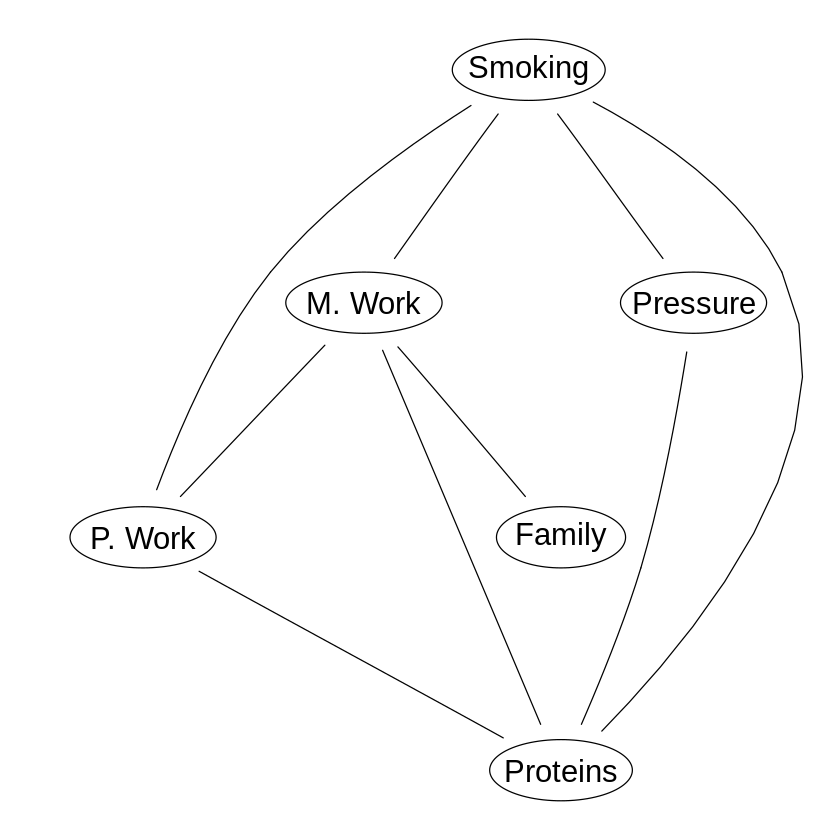

In [29]:
graphviz.plot(ug, shape = "ellipse")

### Ejercicio 1.2

Hemos utilizado la función `arcs()`, pero se puede acceder a la estructura de arcos mediante `dag$arcs`. Añade un arco al grafo del *Ejercicio 1* modificando manualmente esta estructura y observa lo que ocurre para las funciones `parents()`, etc…

**::GMG::** En cierta manera esto ya lo he hecho con `dag` ... ;)

In [22]:
# estado de los nodos y la tabla de probabilidad
estados.A <- c("young", "adult", "old")
estados.S <- c("M", "F")
estados.E <- c("high", "uni")
estados.O <- c("emp","self")
estados.R <- c("small","big")
estados.T <- c("car","train","other")

In [24]:
estados.A

[1] "young" "adult" "old"

In [27]:
A.prob <- array(data = c(.3, .5, .2), dim = 3, dimnames = list(A = estados.A))

In [ ]:
A.prob

In [33]:
S.prob <- array(c(.6, .4), dim = 2, dimnames = list(S = estados.S))

In [ ]:
S.prob

In [28]:
O.prob <- array(c(.96,.04,.92,.08), dim = c(2,2), dimnames = list(O = estados.O, E = estados.E))

In [ ]:
O.prob

In [29]:
R.prob <- array(c(.25,.75,.2,.8), dim = c(2,2), 
                  dimnames = list(R = estados.R, E = estados.E))

In [ ]:
R.prob

In [30]:
E.prob <- array(c(.75, .25, .72, .28, .88, .12, .64, .36, .70, .30, .90, .10),
                dim = c(2, 3, 2),
                dimnames = list(E = estados.E,
                                A = estados.A,
                                S = estados.S))

In [ ]:
E.prob (1,,)

In [31]:
T.prob <- array(c(.48, .42, .1, .56, .36, .08, .58, .24, .18, .7, .21, .09),
                dim = c(3,2,2),
                dimnames = list(T = estados.T, 
                                O = estados.O,
                                R = estados.R))

In [ ]:
T.prob

In [35]:
cpt <- list(A = A.prob, S = S.prob, E = E.prob, O = O.prob, R = R.prob, T = T.prob)

In [36]:
bn <- custom.fit(x = dag, dist = cpt)

In [37]:
# http://www.bnlearn.com/documentation/man/bn.class.html
# http://www.bnlearn.com/documentation/man/bn.fit.class.html
class(bn)

[1] "bn.fit"      "bn.fit.dnet"

In [26]:
# consultas al grafo (no de inferencia)
# x -> y -> z => P(x)p(y/x)p(z/y); x <- y -> z => P(y) p(x/y) P(z/y)
# d-separation => independence becasuse it's an I-graph 
# en el ejercicio 

In [38]:
nbr(dag, "O")

[1] "E" "T"

In [39]:
mb(dag, "O")

[1] "E" "R" "T"

In [43]:
#ejercicio 2: añadir un arco de A a T
dag <- set.arc(dag,from = 'A', to = 'T')

In [44]:
mb(dag, "O")

[1] "A" "E" "R" "T"

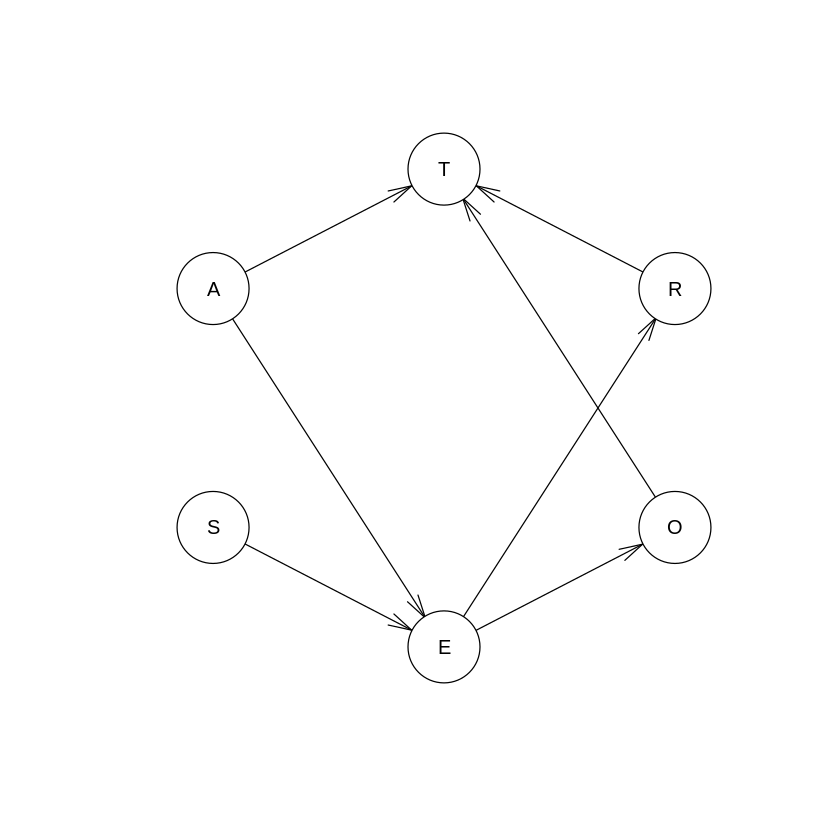

In [45]:
plot(dag)

In [ ]:
# ¿se ha creado una nueva independencia?
# dsep (A, O) dado E; dsep(A, O) dado E,T (E=e, T = t); al añadir A -> T NO se cumple los dsep
#::nota:: iq -> nota <- dif => iq not dsep | nota

In [46]:
dsep(bn = dag, x = 'A' , y = 'O', z = c('E', 'T'))

[1] FALSE

In [47]:
dag <- drop.arc(dag,from = 'A', to = 'T')

In [48]:
dsep(bn = dag, x = 'A' , y = 'O', z = c('E', 'T'))

[1] TRUE

In [ ]:
# en el apartado 3 hay que poner la factorización nueva com p(A/T) como factor
# Z ind U NO
# Z dependiente U no es seguro
# T ind U NO
# T ind U|R SI
# Z ind U |T SI
# Z ind U | T, E SI
# Z ind U | X NO
# ...
# K ind T SI v-structura y no evidenciado (R)
# K ind Z SI
